# Credit Risk Modeling: LGD & EAD Models


Import Libraries and Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [2]:
df_backup = pd.read_csv('/content/cleaned_loan_data_2007-2014_defaults.csv')

## Descriptive Statistics and Distribution Analysis

In [10]:
df = df_backup.copy()
df

,loan_amnt,funded_amnt,default,revol_bal,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,...,Since_issue_d,purpose,zip_code,addr_state,Since_earliest_cr_line,Since_last_pymnt,Since_last_credit_pull,isThreeYearsTerm,Payment_Plan,Initial_Status
0,2500.0,2500.0,1,1687.0,2500.0,15.27,59.83,30000.0,1.00,0.0,...,2192.0,car,309xx,GA,6819.0,1705.0,1552.0,0,0,0
1,5600.0,5600.0,1,5210.0,5600.0,21.28,152.39,40000.0,5.55,0.0,...,2192.0,small_business,958xx,CA,4992.0,2070.0,1948.0,0,0,0
2,5375.0,5375.0,1,9279.0,5350.0,12.69,121.45,15000.0,18.08,0.0,...,2192.0,other,774xx,TX,4839.0,1856.0,1736.0,0,0,0
3,9000.0,9000.0,1,10452.0,9000.0,13.49,305.38,30000.0,10.08,0.0,...,2192.0,debt_consolidation,245xx,VA,4992.0,1979.0,1856.0,1,0,0
4,10000.0,10000.0,1,11997.0,10000.0,10.65,325.74,100000.0,7.06,0.0,...,2192.0,other,951xx,CA,9711.0,1522.0,1371.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50581,6000.0,6000.0,1,1199.0,6000.0,23.40,170.53,45600.0,1.50,1.0,...,1430.0,medical,317xx,GA,12388.0,1340.0,700.0,0,0,0
50582,15000.0,15000.0,1,24551.0,15000.0,16.99,534.72,50000.0,24.39,0.0,...,1430.0,debt_consolidation,196xx,PA,6088.0,1126.0,700.0,1,0,0
50583,8525.0,8525.0,1,5318.0,8525.0,18.25,217.65,37536.0,12.28,4.0,...,1430.0,medical,011xx,MA,8431.0,1310.0,1157.0,0,0,0
50584,18000.0,18000.0,1,8224.0,17975.0,7.90,563.23,90000.0,10.33,1.0,...,1430.0,debt_consolidation,212xx,MD,7093.0,1126.0,1157.0,1,0,0


In [14]:
def describe_dataset(df):
    variables = []
    dtypes = []
    count = []
    unique = []
    missing = []

    for item in df.columns:
        variables.append(item)
        dtypes.append(df[item].dtype)
        count.append(len(df[item]))
        unique.append(len(df[item].unique()))
        missing.append(df[item].isna().sum())

    output = pd.DataFrame({
        'variable': variables,
        'dtype': dtypes,
        'count': count,
        'unique': unique,
        'missing value': missing
    })

    return output

desc_data = describe_dataset(df)
desc_data

,variable,dtype,count,unique,missing value
0,loan_amnt,float64,50586,1179,0
1,funded_amnt,float64,50586,1188,0
2,default,int64,50586,1,0
3,revol_bal,float64,50586,25952,0
4,funded_amnt_inv,float64,50586,2951,0
5,int_rate,float64,50586,494,0
6,installment,float64,50586,21519,0
7,annual_inc,float64,50586,5566,0
8,dti,float64,50586,3755,0
9,delinq_2yrs,float64,50586,19,0


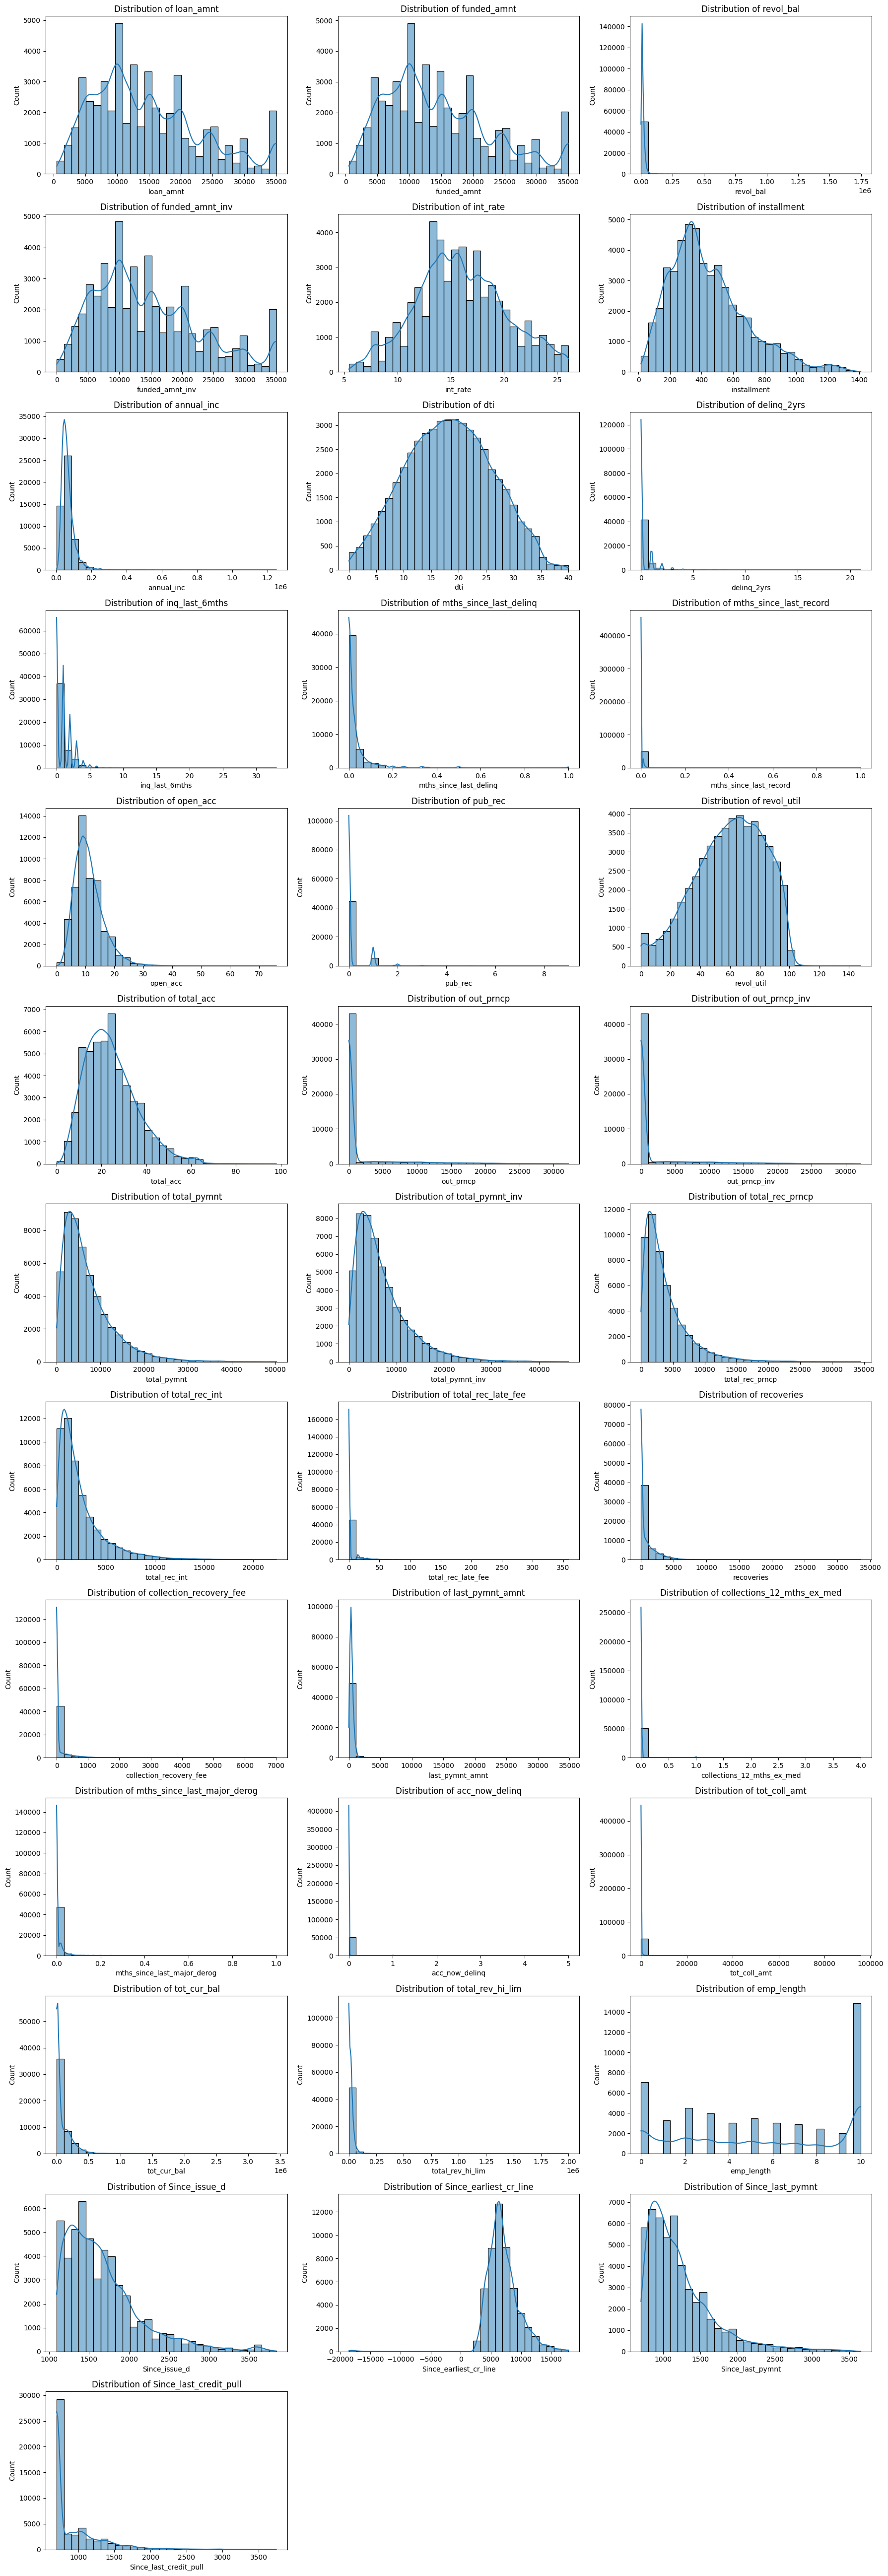

In [11]:
def plot_feature_distributions(df, features, n_cols=2):
    n_features = len(features)
    n_rows = int(np.ceil(n_features / n_cols))

    plt.figure(figsize=(n_cols * 6, n_rows * 4))

    for i, col in enumerate(features):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')

    plt.tight_layout()
    plt.show()

numerical = df.select_dtypes('float').columns.values
plot_feature_distributions(df, numerical, n_cols=3)

In [ ]:
df['Since_earliest_cr_line'] = df['Since_earliest_cr_line'].clip(lower=0)

## Correlation and Relationships

### Dependent Variable

In [ ]:
# The dependent variable for the LGD model: recovery rate
# = the ratio of recoveries and funded amount
df['recovery_rate'] = df['recoveries'] / df['funded_amnt']
df.drop('recoveries', axis=1, inplace=True)
df['recovery_rate'].describe()

,recovery_rate
count,50586.000000
mean,0.051224
std,0.084462
min,0.000000
25%,0.000000
50%,0.000000
75%,0.101450
max,1.220774


In [ ]:
df['recovery_rate'][df['recovery_rate']>1].count()

22

In [ ]:
df = df[df['recovery_rate']<=1]

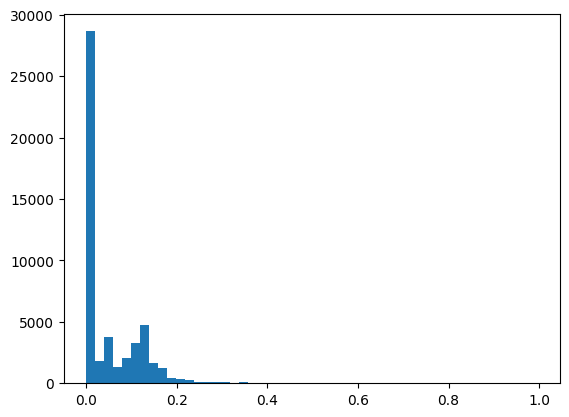

In [ ]:
plt.hist(df['recovery_rate'], bins = 50);

### Correlation matrix of top numerical features

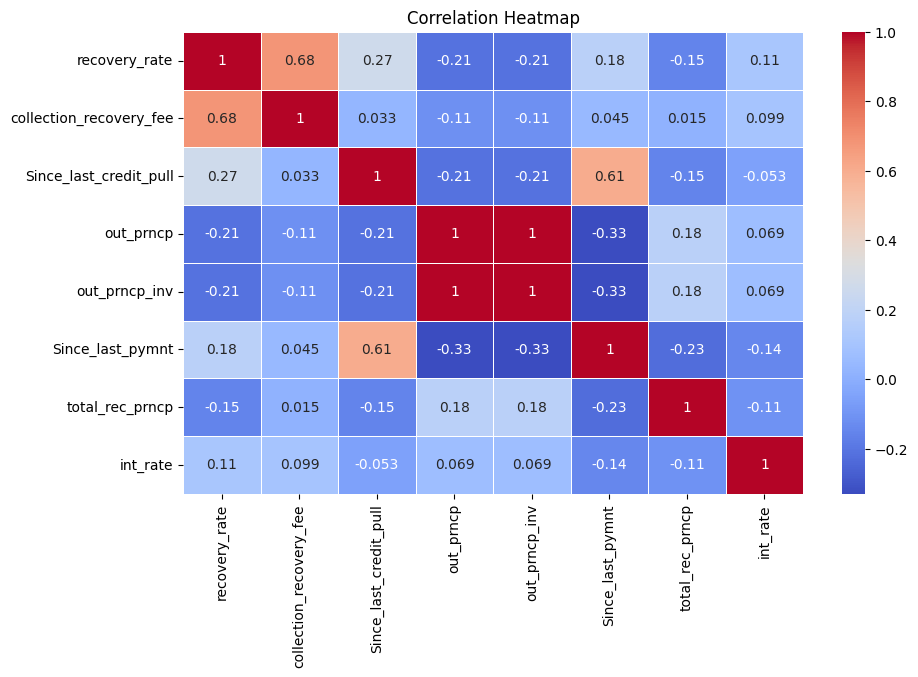

In [ ]:
numerical = df.select_dtypes('float').columns.values
target_corr = df[numerical].corr()['recovery_rate'].abs().sort_values(ascending=False)
top_features = target_corr[target_corr > 0.1].index.tolist()

# Correlation heatmap of top features
plt.figure(figsize=(10, 6))
sns.heatmap(df[top_features].corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

## Recovery rate and categorical features

In [ ]:
categorical = df.select_dtypes('O').columns.values
categorical

array(['grade', 'sub_grade', 'home_ownership', 'verification_status',
       'purpose', 'zip_code', 'addr_state'], dtype=object)

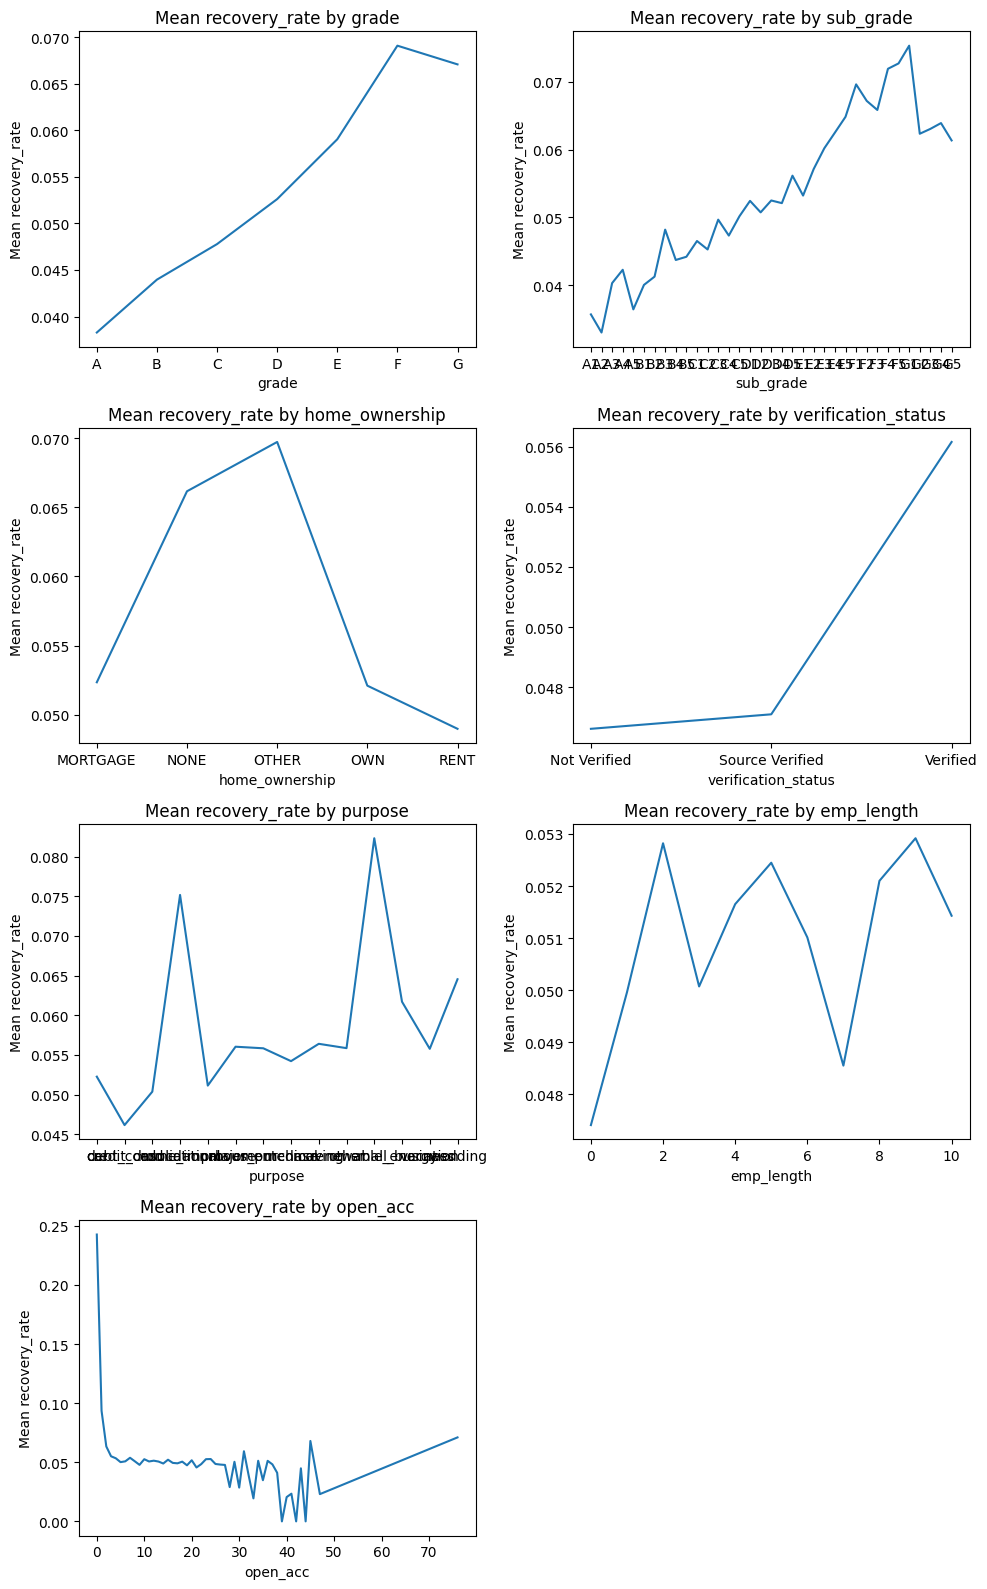

In [ ]:
def plot_mean_by_category(df, features, target, n_cols=3):
    n_rows = math.ceil(len(features) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()

    for idx, col in enumerate(features):
        mean_values = df.groupby(col)[target].mean().reset_index()

        sns.lineplot(x=col, y=target, data=mean_values, ax=axes[idx])
        axes[idx].set_title(f'Mean {target} by {col}')
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel(f'Mean {target}')

    # Hide any empty subplots
    for i in range(len(features), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

features = ['grade', 'sub_grade', 'home_ownership', 'verification_status',
            'purpose', 'emp_length', 'open_acc']
plot_mean_by_category(df, features, 'recovery_rate', n_cols=2)

### Recovery rate by state

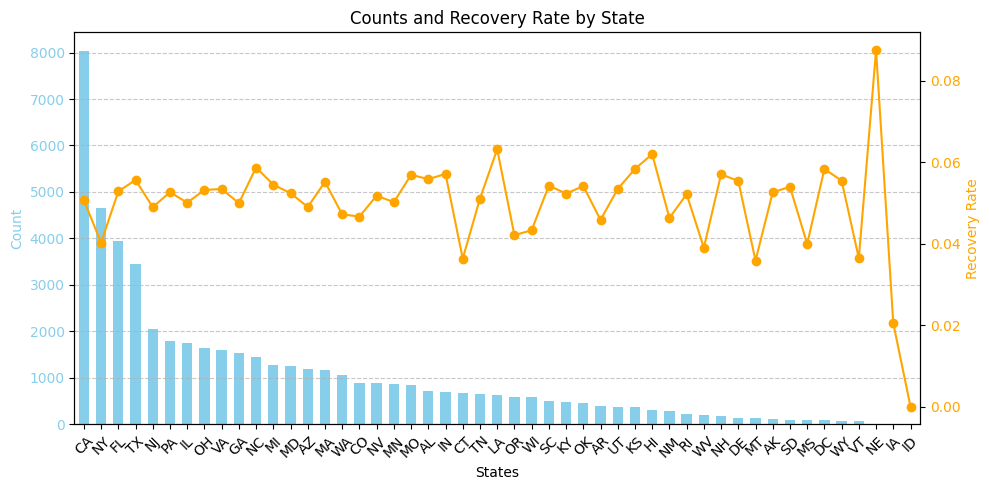

In [ ]:
recovery_rate_by_state = df.groupby('addr_state')['recovery_rate'].mean()
state_counts = df['addr_state'].value_counts()

fig, ax1 = plt.subplots(figsize=(10, 5))

state_counts.plot(kind='bar', ax=ax1, color='skyblue', width=0.6)
ax1.set_xlabel('States')
ax1.set_ylabel('Count', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_xticklabels(state_counts.index, rotation=45)

ax2 = ax1.twinx()
recovery_rate_by_state[state_counts.index].plot(kind='line', ax=ax2, color='orange', marker='o')
ax2.set_ylabel('Recovery Rate', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Counts and Recovery Rate by State')

plt.tight_layout()
plt.show()


The least represented states:

In [ ]:
state_counts.sort_values()[:10]

,count
addr_state,
ID,1
IA,3
NE,8
VT,78
WY,83
DC,96
MS,104
SD,105
AK,109


The outlier states can degrade the performance of the model, so we'll remove them. This won't cause any major information loss, as their representation in the dataset is negligible. Later we'll measure the exact impact of these outliers on the model.

In [ ]:
states_to_remove = ['NE', 'ID', 'IA']
df = df[~df['addr_state'].isin(states_to_remove)]

### Recovery by purpose

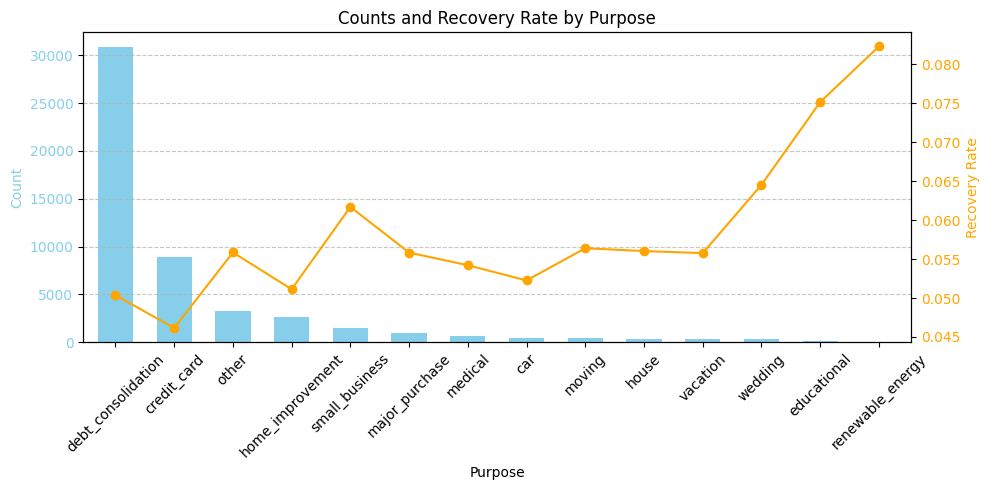

In [ ]:
recovery_rate_by_purpose = df.groupby('purpose')['recovery_rate'].mean()
purpose_counts = df['purpose'].value_counts()

fig, ax1 = plt.subplots(figsize=(10, 5))

purpose_counts.plot(kind='bar', ax=ax1, color='skyblue', width=0.6)
ax1.set_xlabel('Purpose')
ax1.set_ylabel('Count', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_xticklabels(purpose_counts.index, rotation=45)

ax2 = ax1.twinx()
recovery_rate_by_purpose[purpose_counts.index].plot(kind='line', ax=ax2, color='orange', marker='o')
ax2.set_ylabel('Recovery Rate', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

plt.title('Counts and Recovery Rate by Purpose')

plt.tight_layout()
plt.show()

In [ ]:
purpose_counts.sort_values()

,count
purpose,
renewable_energy,52
educational,85
wedding,272
vacation,290
house,313
moving,451
car,473
medical,602
major_purchase,925


## Recovery rate and numerical features

In [ ]:
numerical = df.select_dtypes('float').columns.values
numerical

array(['loan_amnt', 'funded_amnt', 'revol_bal', 'funded_amnt_inv',
       'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'mths_since_last_delinq',
       'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_util',
       'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'collection_recovery_fee', 'last_pymnt_amnt',
       'collections_12_mths_ex_med', 'mths_since_last_major_derog',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'emp_length', 'Since_issue_d',
       'Since_earliest_cr_line', 'Since_last_pymnt',
       'Since_last_credit_pull', 'recovery_rate'], dtype=object)

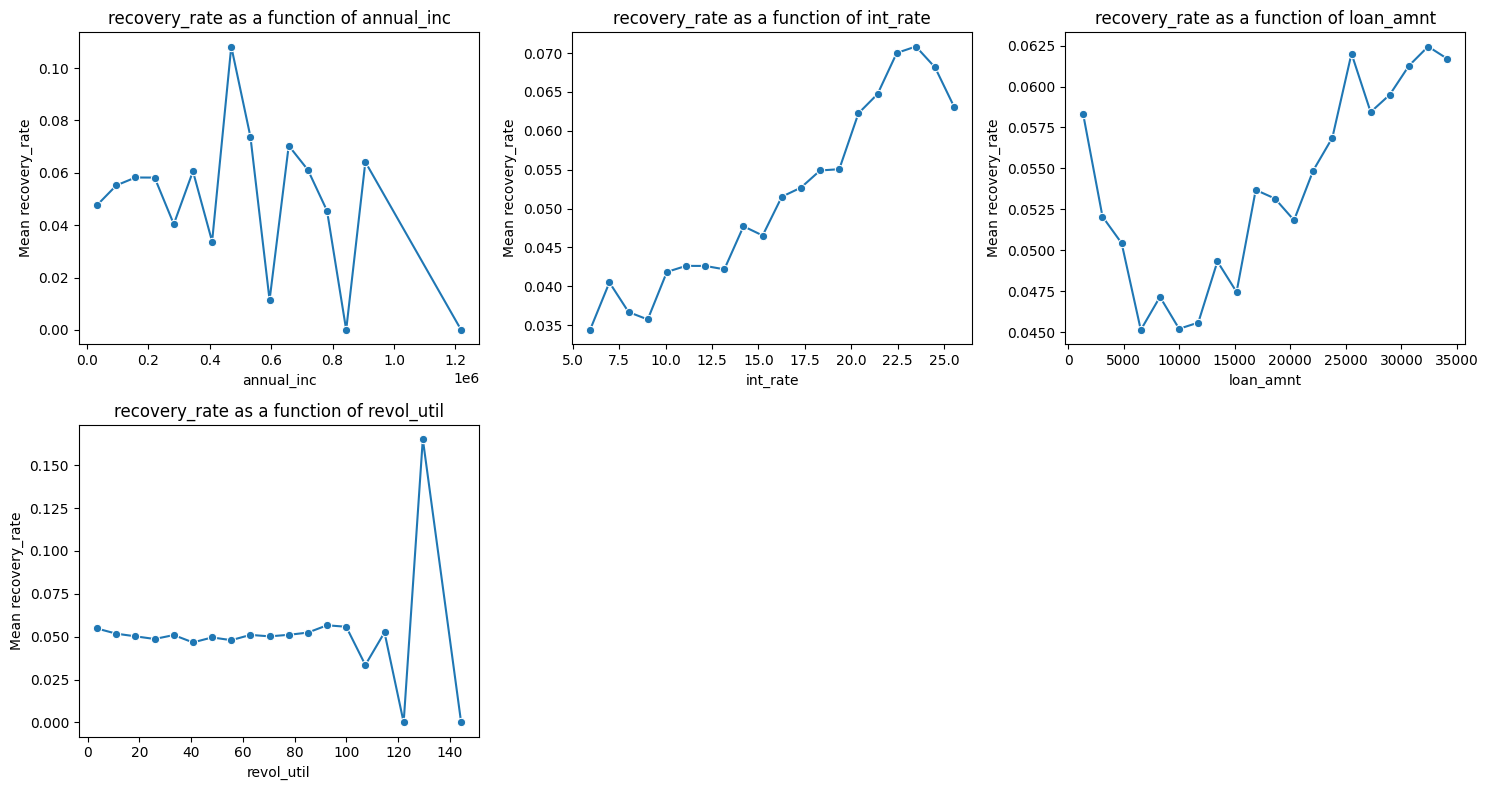

In [ ]:
def plot_target_by_continuous(df, features, target, n_cols=3, bins=20):
    n_rows = math.ceil(len(features) / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
    axes = axes.flatten()

    for idx, cont_col in enumerate(features):
        df_binned = df.copy()
        df_binned['binned'] = pd.cut(df_binned[cont_col], bins)

        mean_values = df_binned.groupby('binned', observed=False)[target].mean().reset_index()
        bin_centers = mean_values['binned'].apply(lambda x: x.mid)  # Get bin midpoints

        sns.lineplot(x=bin_centers, y=mean_values[target], ax=axes[idx], marker='o')
        axes[idx].set_title(f'{target} as a function of {cont_col}')
        axes[idx].set_xlabel(cont_col)
        axes[idx].set_ylabel(f'Mean {target}')

    for i in range(len(features), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

features = ['annual_inc', 'int_rate', 'loan_amnt', 'revol_util']
plot_target_by_continuous(df, features, 'recovery_rate', n_cols=3, bins=20)

# LGD Modelling

## The model

A first model

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

X = df.drop(['recovery_rate','zip_code', 'addr_state', 'grade'], axis=1)
y = df['recovery_rate']

categorical = X.select_dtypes('O').columns

for col in categorical:
    X[col] = X[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=100,
                                 max_depth=5,
                                 learning_rate=0.1,
                                 enable_categorical=True,
                                 tree_method="hist")

xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

r2_score = xgb_regressor.score(X_test, y_test)
print(f"R-squared: {r2_score}")

Mean Absolute Error: 0.005833421382395221
R-squared: 0.9445618482041427


## Model Evaluation

Besides the MAE and the R-squared metrics, used above, there many other visual and non-visual methods to evaluate the performance of the model.

### Actual vs Predicted

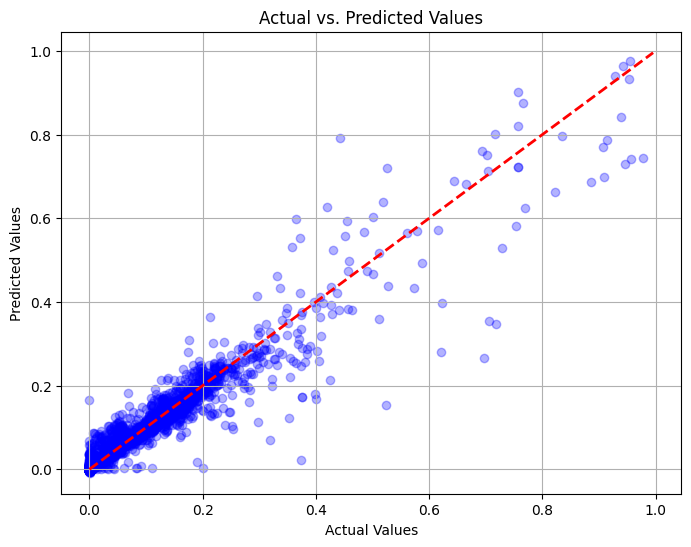

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.3, color='b')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.grid(True)
plt.show()

### Risiduals

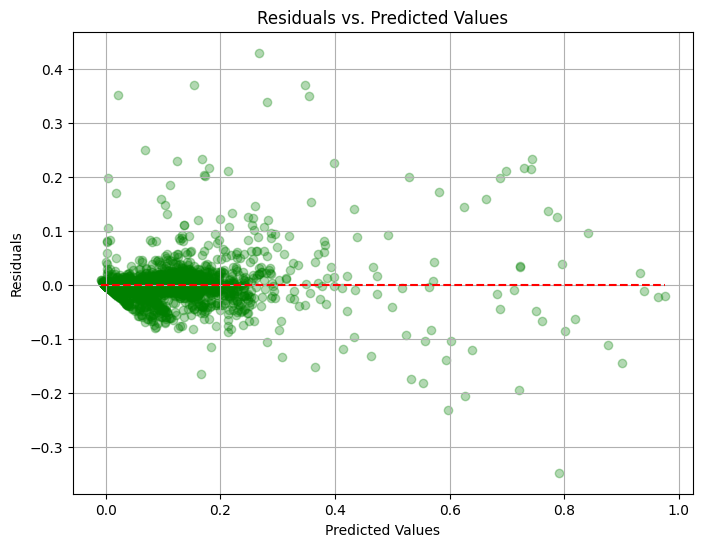

In [ ]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.3, color='g')
plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.grid(True)
plt.show()


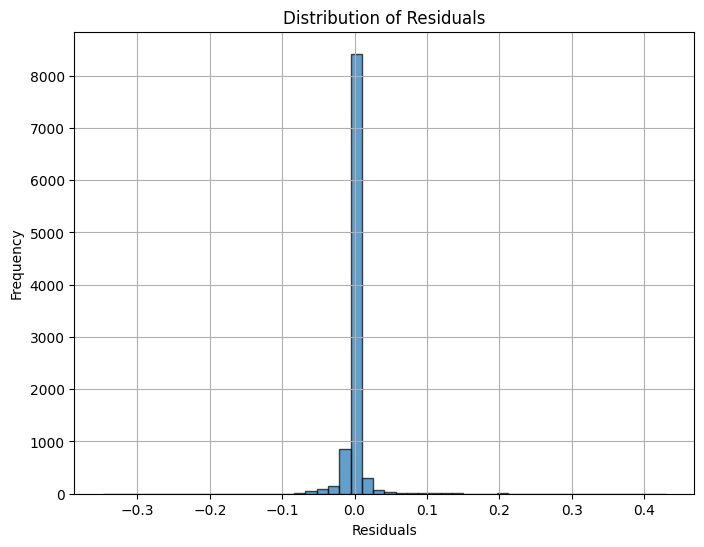

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=50, edgecolor='k', alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.grid(True)
plt.show()

## Model Interpretation

### Feature importance

**Importance by Gain**

<Figure size 1200x800 with 0 Axes>

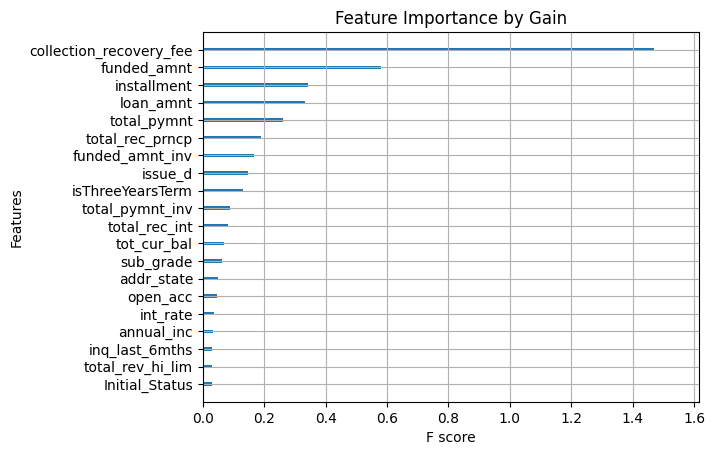

In [ ]:
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_regressor, max_num_features=20, importance_type='gain', show_values=False)
plt.title('Feature Importance by Gain')
plt.show()


**Permutation Importance**

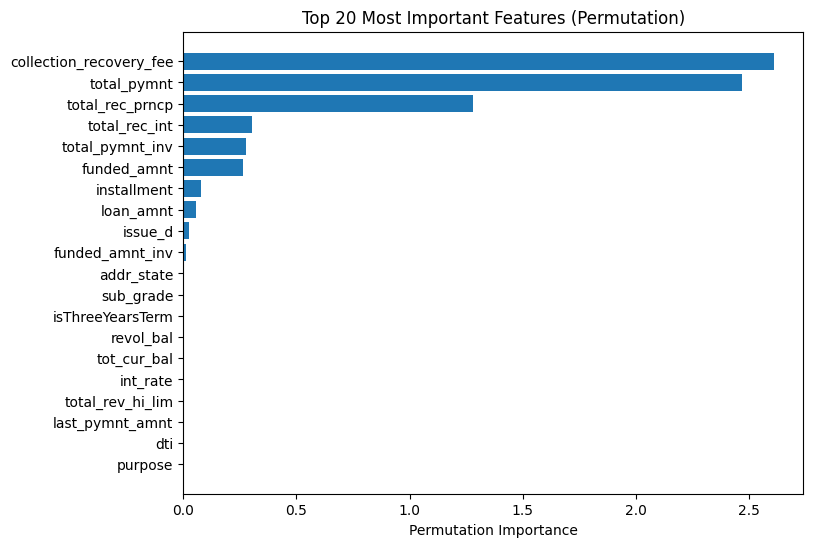

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(xgb_regressor, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
top_features = 20
perm_sorted_idx = result.importances_mean.argsort()[-top_features:]

plt.figure(figsize=(8, 6))
plt.barh(X_test.columns[perm_sorted_idx], result.importances_mean[perm_sorted_idx])
plt.xlabel("Permutation Importance")
plt.title(f"Top {top_features} Most Important Features (Permutation)")
plt.show()

## Model Analysis

* Clip negative values in `Since_earliest_cr_line`
* Drop egative values in `Since_earliest_cr_line`
* With and without `zip_code`
* With and without outlier states
* With and without `grade`
* With and without normalization



In [44]:
df = df_backup.copy()
df['recovery_rate'] = df['recoveries'] / df['funded_amnt']
df.drop('recoveries', axis=1, inplace=True)
df = df[df['recovery_rate']<=1]

In [45]:
desc = describe_dataset(df.select_dtypes('float'))
num_cols = desc[desc['unique']>99]['variable'].values


array(['loan_amnt', 'funded_amnt', 'revol_bal', 'funded_amnt_inv',
       'int_rate', 'installment', 'annual_inc', 'dti',
       'mths_since_last_delinq', 'mths_since_last_record', 'revol_util',
       'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee',
       'collection_recovery_fee', 'last_pymnt_amnt',
       'mths_since_last_major_derog', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'Since_earliest_cr_line', 'recovery_rate'],
      dtype=object)

In [54]:
num_cols = num_cols[:-1]

In [55]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools

def filter_outlier_states(df):
    states_to_remove = ['NE', 'ID', 'IA']
    return df[~df['addr_state'].isin(states_to_remove)]

def generate_combinations(df, clip_neg_values=False, remove_zip_code=False, remove_outlier_states=False, remove_grade=False, normalize=False):
    X = df.copy()

    if clip_neg_values:
        df['Since_earliest_cr_line'] = df['Since_earliest_cr_line'].clip(lower=0)
    else:
        df['Since_earliest_cr_line'] = df['Since_earliest_cr_line'].dropna()

    if remove_zip_code:
        X = X.drop('zip_code', axis=1)

    if remove_grade:
        X = X.drop('grade', axis=1)

    if remove_outlier_states:
        X = filter_outlier_states(X)

    y = X['recovery_rate']
    X = X.drop('recovery_rate', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if normalize:
        scaler = StandardScaler()
        X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
        X_test[num_cols] = scaler.transform(X_test[num_cols])

    return X_train, X_test, y_train, y_test

def train_and_evaluate(X_train, X_test, y_train, y_test):
    for col in X_train.select_dtypes('O').columns:
        X_train[col] = X_train[col].astype('category')
    for col in X_test.select_dtypes('O').columns:
        X_test[col] = X_test[col].astype('category')

    xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=100,
                                 max_depth=5,
                                 learning_rate=0.1,
                                 enable_categorical=True,
                                 tree_method="hist")

    xgb_regressor.fit(X_train, y_train)

    y_pred = xgb_regressor.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    r2_score = xgb_regressor.score(X_test, y_test)
    return mae, r2_score

In [56]:
neg_values_options = [False, True]
zip_code_options = [False, True]
outlier_states_options = [False, True]
grade_options = [False, True]
normalization_options = [False, True]

combinations = list(itertools.product(
    neg_values_options, zip_code_options, outlier_states_options,
    grade_options, normalization_options)
)

results = []

for combination in combinations:
    clip_neg_values, remove_zip_code, remove_outlier_states, remove_grade, normalize = combination

    X_train, X_test, y_train, y_test = generate_combinations(df,
                                                             clip_neg_values=clip_neg_values,
                                                             remove_zip_code=remove_zip_code,
                                                             remove_outlier_states=remove_outlier_states,
                                                             remove_grade=remove_grade,
                                                             normalize=normalize)

    mae, r2_score = train_and_evaluate(X_train, X_test, y_train, y_test)

    results.append({
        'clip_neg_values' : clip_neg_values,
        'remove_zip_code' : remove_zip_code,
        'remove_outlier_states' : remove_outlier_states,
        'remove_grade' : remove_grade,
        'normalize' : normalize,
        'mae' : mae,
        'r2_score' : r2_score,
    })

results_df = pd.DataFrame(results)
results_df

,clip_neg_values,remove_zip_code,remove_outlier_states,remove_grade,normalize,mae,r2_score
0,False,False,False,False,False,0.009217,0.811073
1,False,False,False,False,True,0.009241,0.808493
2,False,False,False,True,False,0.009228,0.808756
3,False,False,False,True,True,0.009246,0.806972
4,False,False,True,False,False,0.009481,0.803043
5,False,False,True,False,True,0.009471,0.803899
6,False,False,True,True,False,0.009484,0.802529
7,False,False,True,True,True,0.009476,0.802938
8,False,True,False,False,False,0.006046,0.930882
9,False,True,False,False,True,0.006046,0.930882


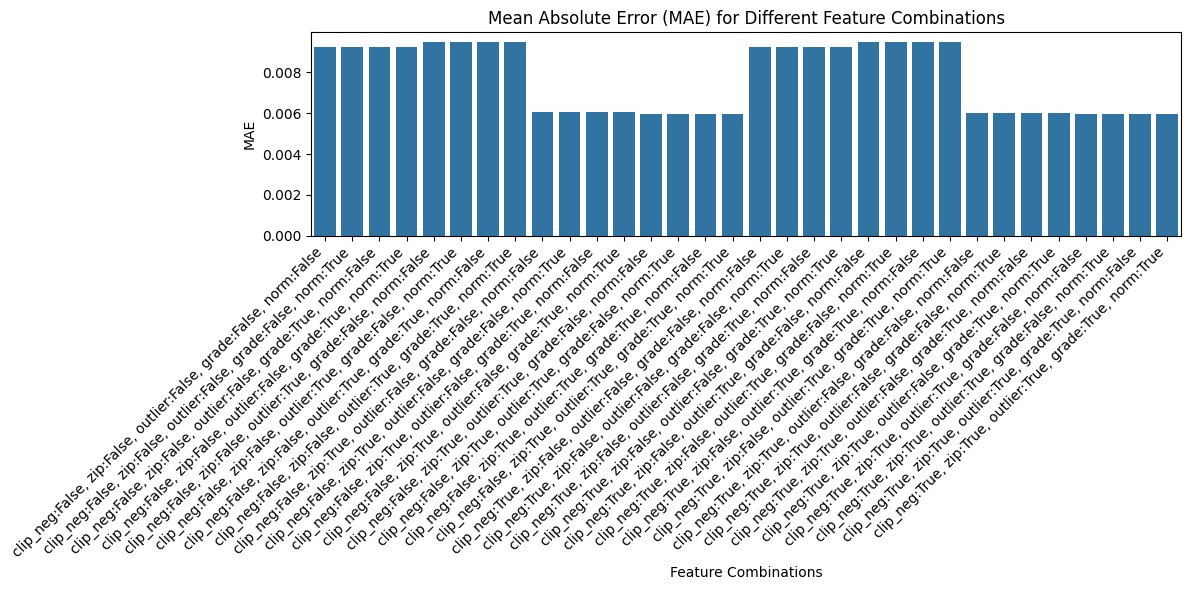

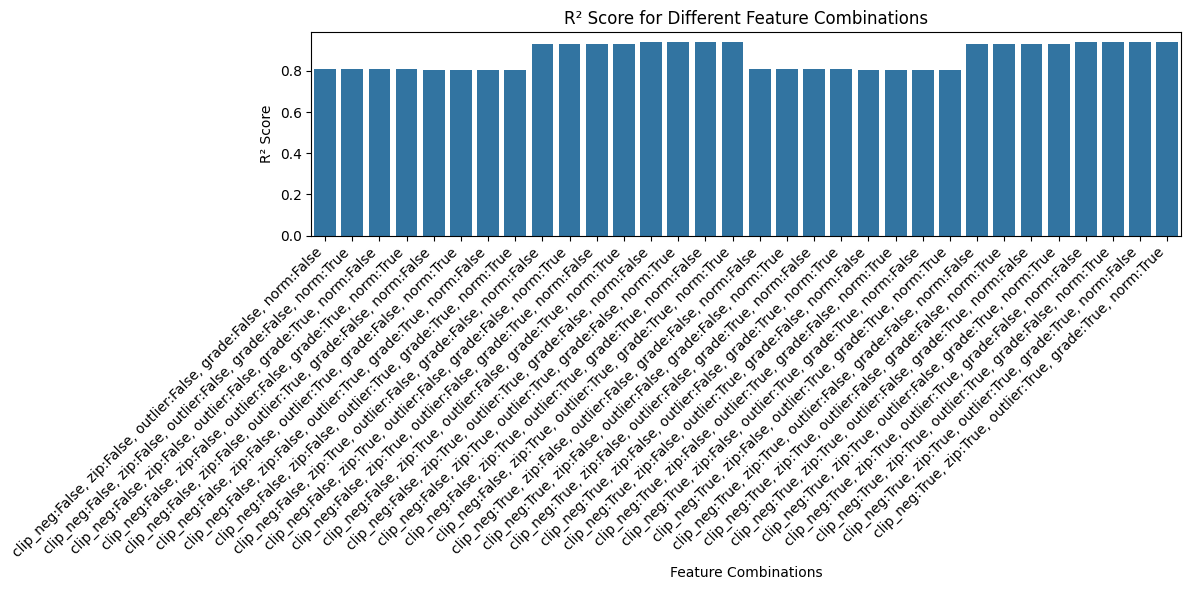

In [59]:
results_df['combination'] = results_df.apply(
    lambda row: f"clip_neg:{row['clip_neg_values']}, zip:{row['remove_zip_code']}, outlier:{row['remove_outlier_states']}, grade:{row['remove_grade']}, norm:{row['normalize']}", axis=1)

# Plot MAE
plt.figure(figsize=(12, 6))
sns.barplot(x='combination', y='mae', data=results_df)
plt.xticks(rotation=45, ha='right')
plt.title('Mean Absolute Error (MAE) for Different Feature Combinations')
plt.xlabel('Feature Combinations')
plt.ylabel('MAE')
plt.tight_layout()
plt.show()

# Plot R² Score
plt.figure(figsize=(12, 6))
sns.barplot(x='combination', y='r2_score', data=results_df)
plt.xticks(rotation=45, ha='right')
plt.title('R² Score for Different Feature Combinations')
plt.xlabel('Feature Combinations')
plt.ylabel('R² Score')
plt.tight_layout()
plt.show()


In [60]:
best_r2_index = results_df['r2_score'].idxmax()
best_combination = results_df.loc[best_r2_index]
print("Best Combination based on R² Score:")
print(best_combination)

Best Combination based on R² Score:
clip_neg_values                                                      False
remove_zip_code                                                       True
remove_outlier_states                                                 True
remove_grade                                                         False
normalize                                                            False
mae                                                               0.005955
r2_score                                                          0.939687
combination              clip_neg:False, zip:True, outlier:True, grade:...
Name: 12, dtype: object


# EAD Modelling

## The dependent variable

In [ ]:
df.loc[:,'CCF'] = (df['funded_amnt'] - df['total_rec_prncp']) / df['funded_amnt']
df['CCF'].describe()

,CCF
count,50552.000000
mean,0.717163
std,0.204088
min,0.000000
25%,0.607051
50%,0.767829
75%,0.874025
max,1.000000


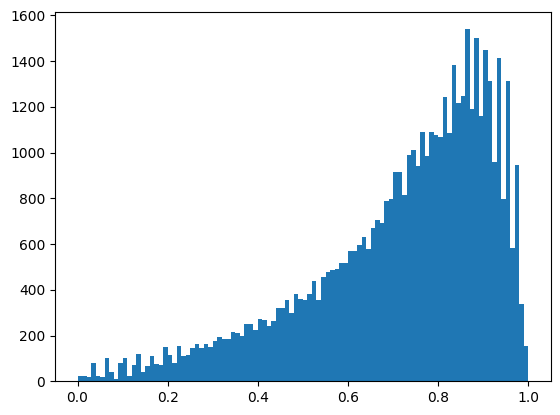

In [ ]:
plt.hist(df['CCF'], bins = 100);

## The model

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

X = df.drop(['recovery_rate','zip_code', 'addr_state', 'grade', 'total_rec_prncp'], axis=1)
y = df['CCF']

categorical = X.select_dtypes('O').columns

for col in categorical:
    X[col] = X[col].astype('category')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_regressor = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=100,
                                 max_depth=5,
                                 learning_rate=0.1,
                                 enable_categorical=True,
                                 tree_method="hist")

xgb_regressor.fit(X_train, y_train)

y_pred = xgb_regressor.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

r2_score = xgb_regressor.score(X_test, y_test)
print(f"R-squared: {r2_score}")